In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPool1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [3]:
df['targets'] = df['labels'].astype('category').cat.codes

In [4]:
# number of classes
K = df['targets'].max()+1
K

5

In [5]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [22]:
df_train.shape, df_test.shape

((1557, 3), (668, 3))

In [23]:
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

tokenizer.fit_on_texts(df_train['text'])

sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [30]:
print(len(sequences_train), len(sequences_test))

1557 668


In [24]:
#get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 27592 unique tokens.


In [25]:
# pad sequences so that we get a N*T matrix

data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

#get sequence length
T = data_train.shape[1]
print(T)

Shape of data train tensor: (1557, 3484)
3484


In [31]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (668, 3484)


In [32]:
#model

#chossing embedding dimensionality
D = 50

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i) 
x = Conv1D(32, 3, activation = 'relu')(x)
#x = MaxPooling1D(3)(x)
#x = Conv1D(64, 3, activation = 'relu')(x)
#x = MaxPooling1D(3)(x)
#x = Conv1D(128, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)  

model = Model(i,x)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3484)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3484, 50)          1379650   
                                                                 
 conv1d_1 (Conv1D)           (None, 3482, 32)          4832      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,384,647
Trainable params: 1,384,647
Non-trainable params: 0
_________________________________________________

In [34]:
data_train

array([[   0,    0,    0, ...,   14,   10, 1063],
       [   0,    0,    0, ...,   59,    1,  778],
       [   0,    0,    0, ...,   32, 1019,    4],
       ...,
       [   0,    0,    0, ...,   86,  439,    6],
       [   0,    0,    0, ...,   39,   54,  213],
       [   0,    0,    0, ...,    4,   88,  118]], dtype=int32)

In [35]:
model.compile(
    loss = SparseCategoricalCrossentropy(from_logits=True), 
    optimizer = 'adam',
    metrics = ['accuracy']
    )

In [36]:
print('Training model...')
r = model.fit(
    data_train, 
    df_train['targets'], 
    epochs=50,
    validation_data=(data_test, df_test['targets'])
    )

Training model...
Epoch 1/50
49/49 [==============================] - 9s 169ms/step - loss: 1.5717 - accuracy: 0.3365 - val_loss: 1.5046 - val_accuracy: 0.4895
Epoch 2/50
49/49 [==============================] - 7s 150ms/step - loss: 1.3535 - accuracy: 0.7136 - val_loss: 1.2079 - val_accuracy: 0.7874
Epoch 3/50
49/49 [==============================] - 7s 149ms/step - loss: 0.9130 - accuracy: 0.9043 - val_loss: 0.7346 - val_accuracy: 0.8847
Epoch 4/50
49/49 [==============================] - 8s 165ms/step - loss: 0.4590 - accuracy: 0.9390 - val_loss: 0.4129 - val_accuracy: 0.9087
Epoch 5/50
49/49 [==============================] - 7s 146ms/step - loss: 0.2429 - accuracy: 0.9647 - val_loss: 0.2962 - val_accuracy: 0.9222
Epoch 6/50
49/49 [==============================] - 8s 165ms/step - loss: 0.1530 - accuracy: 0.9750 - val_loss: 0.2463 - val_accuracy: 0.9326
Epoch 7/50
49/49 [==============================] - 8s 156ms/step - loss: 0.1043 - accuracy: 0.9878 - val_loss: 0.2203 - val_accur

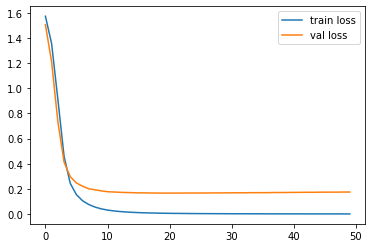

In [37]:
#plot loss per iteration
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show();

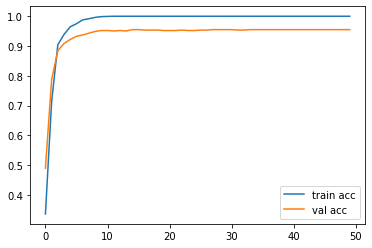

In [38]:
#accuracy per iteration
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show();